# Getting Started

Make sure to follow all instructions in the [Quick Start](../../README.md#quick-start) section before continuing 

### Import all necessary modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

from scipy.stats import uniform

from smcpy import AdaptiveSampler, VectorMCMC, VectorMCMCKernel
from smcpy.paths import GeometricPath
from smcpy.utils.plotter import *

### Sequential Monte Carlo (SMC) Background Context
**<u>Bayes Theorem</u>**<br />
$$P(\theta | D, M) = \frac{P(D | \theta, M) P(\theta | M)}{\int_{-\infty}^{\infty} P(D | \theta, M) P(\theta | M) d\theta}$$
**<u>Theorem Components</u>**<br />
- $P(\theta | D)$ = Posterior
- $P(D | \theta)$ = Likelihood
- $P(\theta)$ = Prior
- $\int_{-\infty}^{\infty} P(D | \theta) P(\theta) d\theta$ = Marginal Likelihood

**<u>Key</u>**<br />
- $M$ = mathematica model
- $\theta$ = mathematical model parameters
- $D$ = sample


**Prior:** <br />
The assumed distribution of the mathematical model before collecting any samples<br />
**Likelihood:** <br />
Probability of the specific data point occuring given the mathematical model<br />
**Posterior:** <br />
Probability of our mathematical model given our sample<br />
**Marginal Likelihood:** <br />
Normalizing constant to make sure the posterior distribution integrates to 1

The marginal probability component is usually difficult to compute. Therefore we focus on the proportionality,
$$P(\theta | D) \propto P(D | \theta) P(\theta)$$

### What is Sequential Monte Carlo (SMC)?
**<u>Purpose</u>**<br />
SMC is used for solving stochastic inverse problems. The goal of stochastic inverse problems is to determine the parameter distribution based on output data.

**<u>Main SMC Steps</u>**<br />
SMC is broken up to the following main steps:
1. Initialize by taking the number of wanted samples from the prior distribution.
2. Define the **target distribution**.
3. Weight each sample based on the **target distribution**.
4. Resample lower weight samples around higher weight samples
5. Use MCMC to apply a random walk around each sample. 
6. Repeat steps 2 to 5 until the target distribution reaches the posterior distribution (goes through the entirety of the phi sequence).
 
**<u>Target Distribution</u>** <br />
The target distribution, $P_t(\theta | D)$, is represented as,
$$P_t(\theta | D) = P(D | \theta)^{\phi_t} P(\theta)$$
Where $\phi_t$ is part of the increasing phi sequence,
$$[0, \dots, \phi_t, \dots, 1]$$

**<u>Key</u>** <br />
- $\phi_t$ = value between $[0 - 1]$ <br />
- $t = 1, 2, \dots, T$
- $T$ = the total length of the $\phi$ sequence.

Note: <br />
$\phi_t$ = 0 means that the taret distribution directly resembles the prior <br />
$\phi_t$ = 1 means that the target distribution directly resembles our posterior.

# Example Problem: Linear Model


### Problem Description
The linear model is represented as $y = Ax + B$, where $A$ and $B$ are the input parameters. <br />
Given a dataset of $y$ values, determine the parameter distribution for $A$ and $B$ using SMC. <br />

### Create Linear Model

In the `eval_model` function:

`a = theta[:, 0, None]` uses numpy vectorization to collect all the $A$ parameter values by going through all rows and collecting it from the 0th column. <br />
`b = theta[:, 1, None]` is a similar process but collects the $B$ parameter values from the 1st column instead. <br />
`None` makes sure to turn the output from a 1d numpy array into a 2d numpy array. This makes sure our numpy arrays are formatted correctly for element by element multiplication in `a * np.arange(100) + b`

Ex:
```
theta = 
    [[2 4] 
    [4 5]]
```
Without `None`: 
```
theta[:, 0]
a = [2 4]
```

With `None`:
```
theta[:, 0, None]
a = 
    [[2] 
    [4]]
```

In [2]:
def eval_model(theta):
    time.sleep(0.1)  # artificial slowdown to show off progress bar
    a = theta[:, 0, None]
    b = theta[:, 1, None]
    return a * np.arange(100) + b

### Generate and Plot Noisy Data Using the Linear Model


The $y$ dataset provided for SMC in this example problem is generated. This is done by applying data noise, $\epsilon$, to the $y$ outputs.
$$y_{error} = y + \epsilon$$

**<u>Key</u>**
- $\epsilon$ = data noise
- $y$ = $y$ output from linear model
- $y_{error}$ = $y$ output with data noise


Assume that the linear model parameters are $A = 2$ and $B = 3.5$. The model equation is now $y = 2x + 3.5$. <br />
Assume that the standard deviation, is $2$.  <br />

In the `generate_data` function:

Determine the seed for the numpy random generator:  <br />
`rng = np.random.default_rng() if rng is None else rng`

Use the linear equation with the assumed $A$ and $B$ parameters and store the output values: <br />
`y_true = eval_model(np.array([[2, 3.5]]))` 

Generate a numpy array with the same size as the output array and generate data naoise: <br />
`noisy_data = y_true + rng.normal(0, std_dev, y_true.shape)` 

`noisy_data` represents as $y_{error}$ in this case.

In [3]:
def plot_noisy_data(x, y_true, noisy_data):
    fig, ax = plt.subplots(1)
    ax.plot(x.flatten(), y_true.flatten(), "-k")
    ax.plot(x.flatten(), noisy_data.flatten(), "o")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.show()

In [4]:
def generate_data(eval_model, std_dev, plot=True, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    y_true = eval_model(np.array([[2, 3.5]]))
    noisy_data = y_true + rng.normal(0, std_dev, y_true.shape)
    if plot:
        plot_noisy_data(np.arange(100), y_true, noisy_data)
    return noisy_data

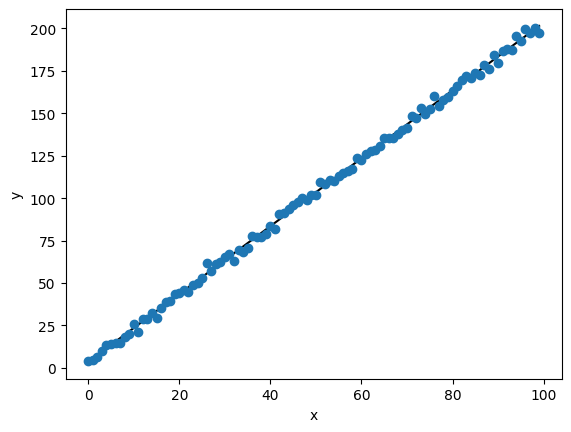

In [5]:
rng = np.random.default_rng(200)
std_dev = 2
noisy_data = generate_data(eval_model, std_dev, plot=True, rng=rng)

### Provide Prior Distributions

Assume that the $A$ and $B$ parameters in the linear model have prior distributions that are uniform distributions when $x$ ranges from $[0, 6]$.

In [6]:
priors = [uniform(0.0, 6.0), uniform(0.0, 6.0)]

### Set Up SMC Sampler Using Linear Model, Noisy Data, Prior Distributions, and Standard Deviation

**<u>Adaptive Sampler:</u>**<br />
Sampler with un-predetermined phi sequence that calculates its phi values as SMC resamples. <br />
Ex: 
$$\phi = [0, ..., ???, 1]$$

**<u>Setting Up SMC:</u>**
1. Provide MCMC algorithm with model, data, priors, and std_dev:<br />
```vector_mcmc = VectorMCMC(eval_model, noisy_data, priors, std_dev)``` 
2. Reformat MCMC class using MCMC Kernel: <br />
```mcmc_kernel = VectorMCMCKernel(vector_mcmc, ("a", "b"), path=path, rng=rng)``` 
3. Perform SMC by applying MCMC Kernel into sampler: <br />
```smc = AdaptiveSampler(mcmc_kernel)```

In [7]:
# require phi=0.2 be included in adaptive sequence
path = GeometricPath(required_phi=0.2)

vector_mcmc = VectorMCMC(eval_model, noisy_data, priors, std_dev)
mcmc_kernel = VectorMCMCKernel(vector_mcmc, ("a", "b"), path=path, rng=rng)
smc = AdaptiveSampler(mcmc_kernel)

### Run SMC

In [8]:

step_list, mll_list = smc.sample(
    num_particles=500, num_mcmc_samples=5, target_ess=0.7, progress_bar=True
)


[ mutation ratio: 0.988: : 100.00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| phi: 1.00000/1.0 [00:08<00:00


### Display SMC Results

phi_sequence=[0.00000000e+00 6.27142981e-06 2.52071999e-05 9.32333696e-05
 3.15864792e-04 1.07582619e-03 3.52370558e-03 1.33535017e-02
 4.16820107e-02 1.11763800e-01 2.00000000e-01 4.26099501e-01
 9.58277982e-01 1.00000000e+00]
fbf norm index=[10]
marginal log likelihood = -227.80537597999762
parameter means = {'a': 2.0013857314580923, 'b': 3.3486198439106842}


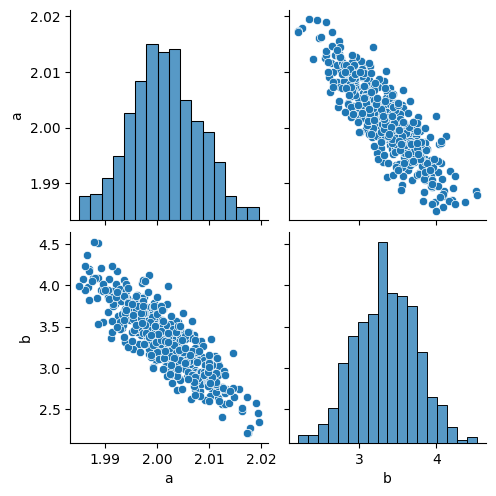

In [9]:

print(f"phi_sequence={smc.phi_sequence}")
print(f"fbf norm index={smc.req_phi_index}")
print("marginal log likelihood = {}".format(mll_list[-1]))
print("parameter means = {}".format(step_list[-1].compute_mean()))

sns.pairplot(pd.DataFrame(step_list[-1].param_dict))
sns.mpl.pyplot.savefig("pairwise.png")
